# Analysis of super-weights in Quen Models

# Setup

In [1]:
from transformers import AutoModel
import torch

In [2]:
model = AutoModel.from_pretrained("Qwen/Qwen2.5-0.5B")
parameters = dict(model.named_parameters())

# Outlier Distribution and Localization

In [3]:
def find_outliers(tensor, threshold=3):
    # Calculate mean and std deviation
    mean = tensor.mean().item()
    std = tensor.std().item()
    # Define outliers as values beyond threshold * std deviation
    outliers = tensor[torch.abs(tensor - mean) > threshold * std]
    return outliers

In [4]:
outlier_stats = {}

for name, param in parameters.items():
    if param.requires_grad:
        total_elements = param.numel()
        outliers = find_outliers(param)
        outlier_stats[name] = {
            "num_outliers": outliers.numel(),
            "proportion_outliers": outliers.numel() / total_elements,
            "max_outlier": outliers.max().item() if outliers.numel() > 0 else None,
            "mean_outlier": outliers.mean().item() if outliers.numel() > 0 else None,
        }

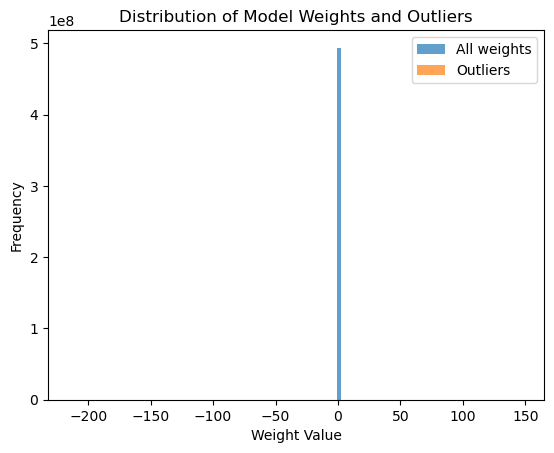

In [5]:
import matplotlib.pyplot as plt

# Collect all weights in a single tensor for visualization
all_weights = torch.cat([param.view(-1) for param in parameters.values() if param.requires_grad])
outliers = find_outliers(all_weights)

# Plot
plt.hist(all_weights.detach().numpy(), bins=100, alpha=0.7, label='All weights')
plt.hist(outliers.detach().numpy(), bins=100, alpha=0.7, label='Outliers')
plt.legend()
plt.title("Distribution of Model Weights and Outliers")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

In [6]:
from collections import defaultdict

layer_outliers = defaultdict(int)

for name, stats in outlier_stats.items():
    if stats["num_outliers"] > 0:
        # Extract the layer index (assuming a BERT-like structure)
        layer_index = name.split(".")[2] if "layer" in name else "other"
        layer_outliers[layer_index] += stats["num_outliers"]

# Sort and display
layer_outliers = dict(sorted(layer_outliers.items(), key=lambda x: x[1], reverse=True))
print(layer_outliers)

{'mlp': 1919587, 'other': 663496, 'self_attn': 501980, 'input_layernorm': 381, 'post_attention_layernorm': 145}


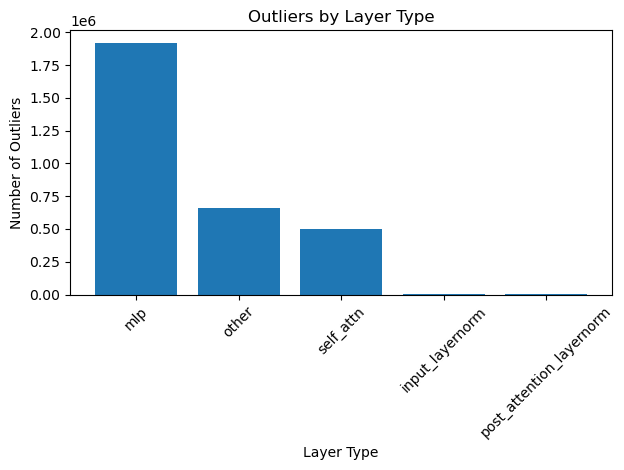

In [7]:
import matplotlib.pyplot as plt

# Data from the outlier analysis
outlier_by_layer_type = {'mlp': 1919587, 'other': 663496, 'self_attn': 501980, 'input_layernorm': 381, 'post_attention_layernorm': 145}

# Create a bar chart
plt.bar(outlier_by_layer_type.keys(), outlier_by_layer_type.values())
plt.title("Outliers by Layer Type")
plt.xlabel("Layer Type")
plt.ylabel("Number of Outliers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

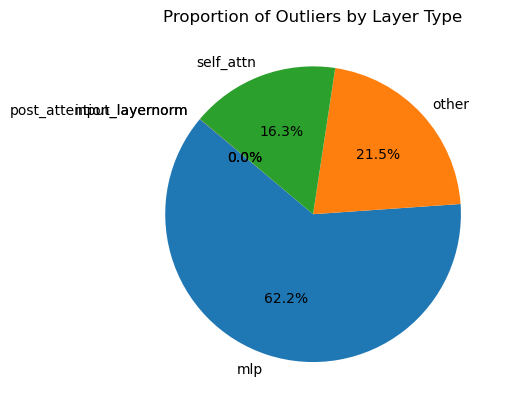

In [8]:
# Create a pie chart
plt.pie(outlier_by_layer_type.values(), labels=outlier_by_layer_type.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Outliers by Layer Type")
plt.show()


In [9]:
# Define a threshold for "high proportion of outliers"
proportion_threshold = 0.03  # Adjust as needed

# Find layers with outlier proportion exceeding the threshold
high_proportion_outlier_layers = {name: stats for name, stats in outlier_stats.items() if stats["proportion_outliers"] > proportion_threshold}

# Sort by proportion of outliers
sorted_high_proportion_outliers = dict(sorted(high_proportion_outlier_layers.items(), key=lambda x: x[1]["proportion_outliers"], reverse=True))

# Display
print(len(sorted_high_proportion_outliers))
print(sorted_high_proportion_outliers)

12
{'layers.2.self_attn.k_proj.bias': {'num_outliers': 7, 'proportion_outliers': 0.0546875, 'max_outlier': 58.75, 'mean_outlier': 22.35714340209961}, 'layers.0.self_attn.k_proj.bias': {'num_outliers': 5, 'proportion_outliers': 0.0390625, 'max_outlier': 121.0, 'mean_outlier': 18.700000762939453}, 'layers.23.input_layernorm.weight': {'num_outliers': 34, 'proportion_outliers': 0.03794642857142857, 'max_outlier': 12.375, 'mean_outlier': 8.522977828979492}, 'layers.21.input_layernorm.weight': {'num_outliers': 31, 'proportion_outliers': 0.03459821428571429, 'max_outlier': 6.78125, 'mean_outlier': 6.328629016876221}, 'layers.22.self_attn.q_proj.bias': {'num_outliers': 29, 'proportion_outliers': 0.03236607142857143, 'max_outlier': 6.34375, 'mean_outlier': -1.9337284564971924}, 'layers.4.self_attn.v_proj.bias': {'num_outliers': 4, 'proportion_outliers': 0.03125, 'max_outlier': 2.4375, 'mean_outlier': 0.169921875}, 'layers.9.self_attn.k_proj.bias': {'num_outliers': 4, 'proportion_outliers': 0.03

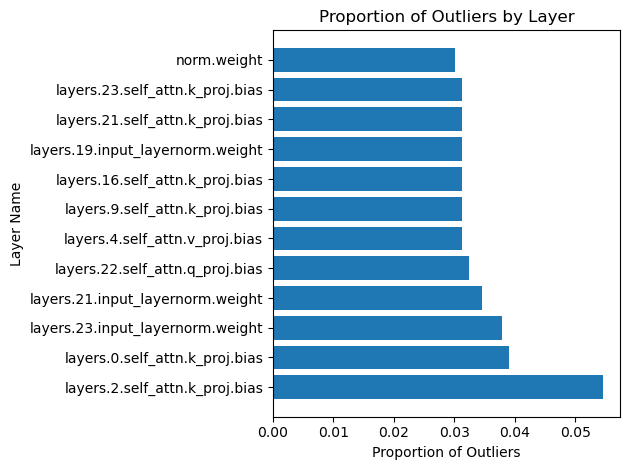

In [10]:
# Extract data for plotting
layer_names = list(sorted_high_proportion_outliers.keys())
proportions = [stats["proportion_outliers"] for stats in sorted_high_proportion_outliers.values()]

# Bar chart
plt.barh(layer_names, proportions)
plt.title("Proportion of Outliers by Layer")
plt.xlabel("Proportion of Outliers")
plt.ylabel("Layer Name")
plt.tight_layout()
plt.show()

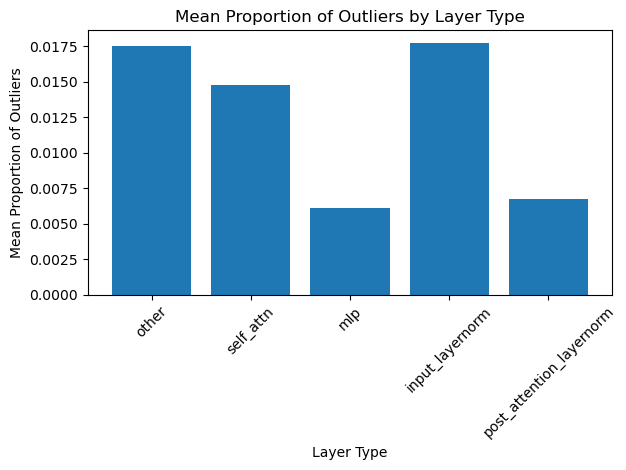

In [11]:
from collections import defaultdict

# Initialize dictionaries
proportions_by_layer_type = defaultdict(list)

# Aggregate proportions by layer type
for name, stats in outlier_stats.items():
    layer_type = (
        "mlp" if "mlp" in name
        else "self_attn" if "self_attn" in name
        else "input_layernorm" if "input_layernorm" in name
        else "post_attention_layernorm" if "post_attention_layernorm" in name
        else "other"
    )
    proportions_by_layer_type[layer_type].append(stats["proportion_outliers"])

# Calculate mean proportion for each layer type
mean_proportions = {layer: sum(proportions) / len(proportions) for layer, proportions in proportions_by_layer_type.items()}

# Plot
plt.bar(mean_proportions.keys(), mean_proportions.values())
plt.title("Mean Proportion of Outliers by Layer Type")
plt.xlabel("Layer Type")
plt.ylabel("Mean Proportion of Outliers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def calculate_sparsity(tensor, threshold=1e-6):
    # Count elements close to zero
    zero_elements = torch.sum(torch.abs(tensor) < threshold).item()
    total_elements = tensor.numel()
    return zero_elements / total_elements

# Extend outlier_stats with sparsity info
for name, param in parameters.items():
    if param.requires_grad:
        outlier_stats[name]["sparsity"] = calculate_sparsity(param)

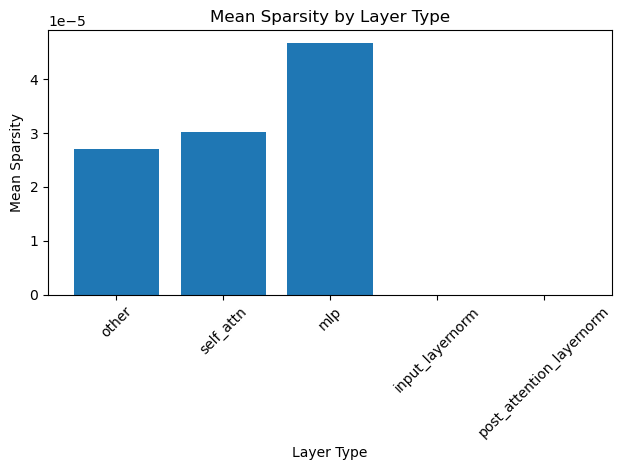

In [13]:
# Aggregate sparsity by layer type
sparsity_by_layer_type = defaultdict(list)

for name, stats in outlier_stats.items():
    layer_type = (
        "self_attn" if "self_attn" in name
        else "input_layernorm" if "input_layernorm" in name
        else "mlp" if "mlp" in name
        else "post_attention_layernorm" if "post_attention_layernorm" in name
        else "other"
    )
    sparsity_by_layer_type[layer_type].append(stats["sparsity"])

# Calculate mean sparsity
mean_sparsity = {layer: sum(sparsities) / len(sparsities) for layer, sparsities in sparsity_by_layer_type.items()}

# Plot mean sparsity
plt.bar(mean_sparsity.keys(), mean_sparsity.values())
plt.title("Mean Sparsity by Layer Type")
plt.xlabel("Layer Type")
plt.ylabel("Mean Sparsity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
def analyze_locality(tensor, axes=(0,)):
    """
    Analyze locality of outliers along specified axes for a tensor of any dimension.

    Args:
    - tensor (torch.Tensor): The tensor to analyze.
    - axes (tuple of int): The axes along which to sum outliers.

    Returns:
    - locality (torch.Tensor): The summed outliers along the specified axes.
    """
    outliers = find_outliers(tensor)
    # Validate axes
    axes = tuple(axis for axis in axes if axis < tensor.dim())
    if not axes:  # If no valid axes, return the outlier tensor itself
        return outliers
    locality = outliers.sum(dim=axes)
    return locality

In [15]:
locality_stats = {}

for name, param in parameters.items():
    if param.requires_grad:
        param = param.detach()
        param_dim = param.dim()
        axis_locality = {}
        for axis in range(param_dim - 1):
            axis_locality[axis] = analyze_locality(param, axes=(axis,)).cpu().numpy()
        locality_stats[name] = axis_locality

In [16]:
locality_stats['layers.0.self_attn.q_proj.weight']

{0: array(21.205078, dtype=float32)}

In [17]:
import numpy as np

def calculate_locality_metrics(locality):
    """
    Compute metrics for locality data.
    
    Args:
    - locality (dict): Dictionary of locality values for each axis.
    
    Returns:
    - metrics (dict): Locality metrics (mean, variance, skewness).
    """
    metrics = {}
    for axis, values in locality.items():
        mean = np.mean(values)
        variance = np.var(values)
        skewness = np.mean((values - mean) ** 3) / (np.std(values) ** 3 + 1e-6)
        metrics[axis] = {"mean": mean, "variance": variance, "skewness": skewness}
    return metrics

In [18]:
locality_metrics = {}

for name, locality in locality_stats.items():
    locality_metrics[name] = calculate_locality_metrics(locality)

In [19]:
locality_metrics

{'embed_tokens.weight': {0: {'mean': np.float32(5813.3896),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.self_attn.q_proj.weight': {0: {'mean': np.float32(21.205078),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.self_attn.q_proj.bias': {},
 'layers.0.self_attn.k_proj.weight': {0: {'mean': np.float32(-15.487305),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.self_attn.k_proj.bias': {},
 'layers.0.self_attn.v_proj.weight': {0: {'mean': np.float32(1.2736816),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.self_attn.v_proj.bias': {},
 'layers.0.self_attn.o_proj.weight': {0: {'mean': np.float32(0.3544922),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.mlp.gate_proj.weight': {0: {'mean': np.float32(113.4541),
   'variance': np.float32(0.0),
   'skewness': np.float32(0.0)}},
 'layers.0.mlp.up_proj.weight': {0: {'mean': np.float32(-2.036865

In [20]:
outlier_values = []

for name, param in parameters.items():
    if param.requires_grad:
        outliers = find_outliers(param)  # Use your outlier detection function
        if outliers.numel() > 0:
            outlier_values.append(outliers.detach().numpy())

# Flatten the list of arrays into a single array
import numpy as np
outlier_values = np.concatenate(outlier_values)

In [21]:
# Descriptive statistics
mean_outlier = np.mean(outlier_values)
median_outlier = np.median(outlier_values)
std_dev_outlier = np.std(outlier_values)
max_outlier = np.max(outlier_values)
min_outlier = np.min(outlier_values)

print("Outlier Statistics:")
print(f"Mean: {mean_outlier}, Median: {median_outlier}")
print(f"Std Dev: {std_dev_outlier}, Max: {max_outlier}, Min: {min_outlier}")

Outlier Statistics:
Mean: 0.002745961770415306, Median: 0.0478515625
Std Dev: 0.32448527216911316, Max: 147.0, Min: -214.0


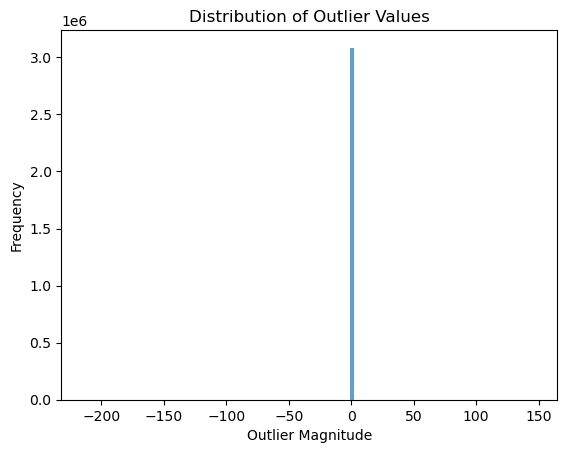

In [22]:
import matplotlib.pyplot as plt

plt.hist(outlier_values, bins=100, alpha=0.7)
plt.title("Distribution of Outlier Values")
plt.xlabel("Outlier Magnitude")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_16420/241628143.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(outlier_values), bins=100, alpha=0.7)


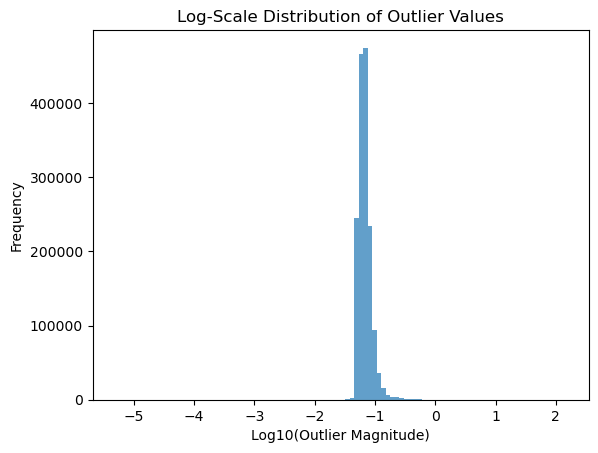

In [23]:
plt.hist(np.log10(outlier_values), bins=100, alpha=0.7)
plt.title("Log-Scale Distribution of Outlier Values")
plt.xlabel("Log10(Outlier Magnitude)")
plt.ylabel("Frequency")
plt.show()

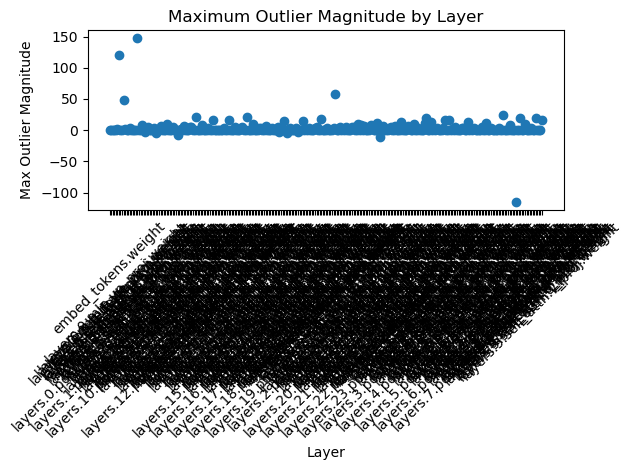

In [24]:
layer_max_outliers = {
    name: find_outliers(param).max().item() 
    for name, param in parameters.items() 
    if param.requires_grad 
    and find_outliers(param).numel() > 0
}

# Sort by layer order (if the names have a natural order)
sorted_layer_max_outliers = dict(sorted(layer_max_outliers.items(), key=lambda x: x[0]))

# Plot
plt.scatter(sorted_layer_max_outliers.keys(), sorted_layer_max_outliers.values(), marker="o")
plt.title("Maximum Outlier Magnitude by Layer")
plt.xlabel("Layer")
plt.ylabel("Max Outlier Magnitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Positive Outliers: 1591043, Negative Outliers: 1494546


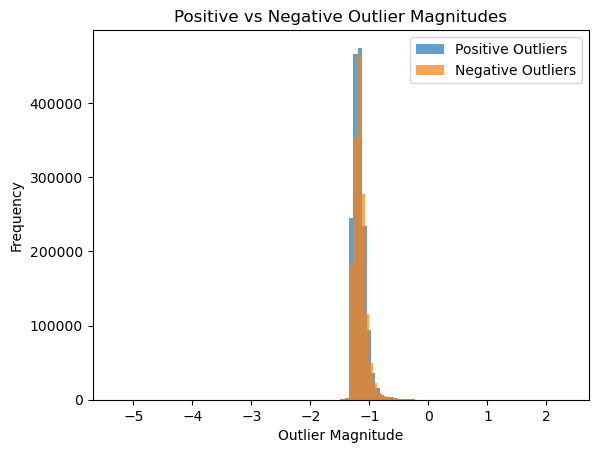

In [25]:
positive_outliers = outlier_values[outlier_values > 0]
negative_outliers = outlier_values[outlier_values < 0]

print(f"Positive Outliers: {len(positive_outliers)}, Negative Outliers: {len(negative_outliers)}")

# Plot histograms for positive and negative outliers
plt.hist(np.log10(positive_outliers), bins=100, alpha=0.7, label="Positive Outliers")
plt.hist(np.log10(np.abs(negative_outliers)), bins=100, alpha=0.7, label="Negative Outliers")
plt.title("Positive vs Negative Outlier Magnitudes")
plt.xlabel("Outlier Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [26]:
layer_sizes = {name: param.numel() for name, param in parameters.items() if param.requires_grad}
outlier_proportions = {name: stats["proportion_outliers"] for name, stats in outlier_stats.items()}

# Correlation between layer size and outlier proportion
sizes = np.array(list(layer_sizes.values()))
proportions = np.array([outlier_proportions[name] for name in layer_sizes.keys()])

correlation = np.corrcoef(sizes, proportions)[0, 1]
print(f"Correlation between layer size and outlier proportion: {correlation}")

Correlation between layer size and outlier proportion: -0.15556196108228826


In [27]:
extreme_outliers = outlier_values[outlier_values > mean_outlier + 10 * std_dev_outlier]
print(f"Number of Extreme Outliers: {len(extreme_outliers)}")

Number of Extreme Outliers: 576


In [28]:
extreme_outlier_layers = []

for name, param in parameters.items():
    if param.requires_grad:
        outliers = find_outliers(param)
        if outliers.numel() > 0 and (outliers > mean_outlier + 10 * std_dev_outlier).any():
            extreme_outlier_layers.append(name)

print("Layers with Extreme Outliers:", extreme_outlier_layers)

Layers with Extreme Outliers: ['layers.0.self_attn.q_proj.bias', 'layers.0.self_attn.k_proj.bias', 'layers.1.self_attn.q_proj.bias', 'layers.1.self_attn.k_proj.bias', 'layers.2.self_attn.q_proj.bias', 'layers.2.self_attn.k_proj.bias', 'layers.2.input_layernorm.weight', 'layers.2.post_attention_layernorm.weight', 'layers.3.self_attn.q_proj.bias', 'layers.3.self_attn.k_proj.bias', 'layers.3.input_layernorm.weight', 'layers.3.post_attention_layernorm.weight', 'layers.4.self_attn.q_proj.bias', 'layers.4.self_attn.k_proj.bias', 'layers.4.input_layernorm.weight', 'layers.4.post_attention_layernorm.weight', 'layers.5.self_attn.q_proj.bias', 'layers.5.self_attn.k_proj.bias', 'layers.5.input_layernorm.weight', 'layers.6.self_attn.q_proj.bias', 'layers.6.self_attn.k_proj.bias', 'layers.6.input_layernorm.weight', 'layers.7.self_attn.q_proj.bias', 'layers.7.self_attn.k_proj.bias', 'layers.7.input_layernorm.weight', 'layers.8.self_attn.q_proj.bias', 'layers.8.input_layernorm.weight', 'layers.9.self

/tmp/ipykernel_16420/1271761068.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([outlier_values_by_layer_type[layer] for layer in outlier_values_by_layer_type.keys()],


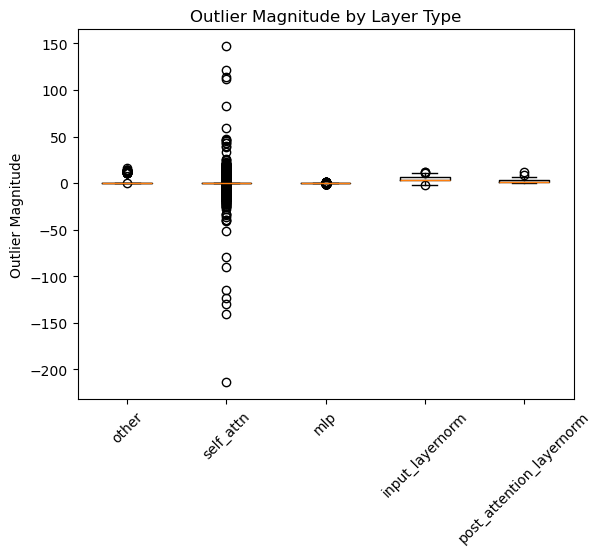

In [29]:
outlier_values_by_layer_type = defaultdict(list)

for name, param in parameters.items():
    if param.requires_grad:
        outliers = find_outliers(param)
        if outliers.numel() > 0:
            layer_type = (
                "mlp" if "mlp" in name
                else "self_attn" if "self_attn" in name
                else "input_layernorm" if "input_layernorm" in name
                else "post_attention_layernorm" if "post_attention_layernorm" in name
                else "other"
            )
            outlier_values_by_layer_type[layer_type].append(outliers.detach().numpy())

# Flatten the arrays for each layer type
for layer_type in outlier_values_by_layer_type:
    outlier_values_by_layer_type[layer_type] = np.concatenate(outlier_values_by_layer_type[layer_type])

# Compare with box plots
plt.boxplot([outlier_values_by_layer_type[layer] for layer in outlier_values_by_layer_type.keys()],
            labels=outlier_values_by_layer_type.keys())
plt.title("Outlier Magnitude by Layer Type")
plt.ylabel("Outlier Magnitude")
plt.xticks(rotation=45)
plt.show()

In [30]:
attention_weights = {
    name: param
    for name, param in parameters.items()
    if 'attn' in name and 'weight' in name and len(param.shape) == 2
}

In [31]:
# Initialize a dictionary to store attention head weights
attention_weights = {}

# Loop through layers to extract query, key, value weights
for name, param in model.named_parameters():
    if "attn" in name and "weight" in name:
        attention_weights[name] = param.detach().cpu().numpy()

print(f"Extracted attention weights for {len(attention_weights)} matrices.")

Extracted attention weights for 96 matrices.


In [32]:
attention_weights.keys()

dict_keys(['layers.0.self_attn.q_proj.weight', 'layers.0.self_attn.k_proj.weight', 'layers.0.self_attn.v_proj.weight', 'layers.0.self_attn.o_proj.weight', 'layers.1.self_attn.q_proj.weight', 'layers.1.self_attn.k_proj.weight', 'layers.1.self_attn.v_proj.weight', 'layers.1.self_attn.o_proj.weight', 'layers.2.self_attn.q_proj.weight', 'layers.2.self_attn.k_proj.weight', 'layers.2.self_attn.v_proj.weight', 'layers.2.self_attn.o_proj.weight', 'layers.3.self_attn.q_proj.weight', 'layers.3.self_attn.k_proj.weight', 'layers.3.self_attn.v_proj.weight', 'layers.3.self_attn.o_proj.weight', 'layers.4.self_attn.q_proj.weight', 'layers.4.self_attn.k_proj.weight', 'layers.4.self_attn.v_proj.weight', 'layers.4.self_attn.o_proj.weight', 'layers.5.self_attn.q_proj.weight', 'layers.5.self_attn.k_proj.weight', 'layers.5.self_attn.v_proj.weight', 'layers.5.self_attn.o_proj.weight', 'layers.6.self_attn.q_proj.weight', 'layers.6.self_attn.k_proj.weight', 'layers.6.self_attn.v_proj.weight', 'layers.6.self_at

In [33]:
# Assuming you want to analyze query weights across heads
import pandas as pd

# Example: Analyzing the first layer's query weights
layer_query_weights = [param for name, param in attention_weights.items() if "k_proj" in name]

# Compute correlations
if layer_query_weights:
    weights = np.stack(layer_query_weights)  # Stack weights into a single array
    reshaped_weights = weights.reshape(weights.shape[0], -1)  # Flatten each weight matrix
    correlation_matrix = np.corrcoef(reshaped_weights)  # Compute correlations

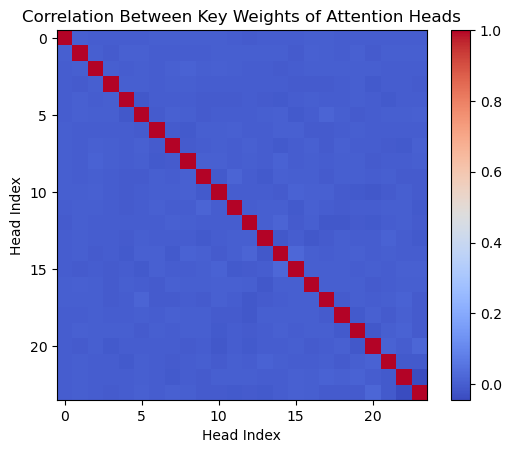

In [34]:
import matplotlib.pyplot as plt

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Between Key Weights of Attention Heads")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

Might suggest some redundancy in model. Would be worth looking at larger models for this

In [35]:
organized_weights = defaultdict(lambda: defaultdict(list))

for name, param in model.named_parameters():
    if "self_attn" in name and "weight" in name:
        parts = name.split(".")
        layer = int(parts[1])  # Extract layer number
        proj_type = parts[-2]  # Extract projection type (q_proj, k_proj, etc.)
        organized_weights[layer][proj_type] = param.detach().cpu().numpy()

print(f"Organized weights for {len(organized_weights)} layers.")


Organized weights for 24 layers.


dict_items([(0, defaultdict(<class 'list'>, {'q_proj': array([[ 0.00253296, -0.00024796,  0.01550293, ..., -0.0004921 ,
        -0.01843262,  0.00384521],
       [ 0.0135498 ,  0.0088501 ,  0.03344727, ...,  0.00805664,
        -0.04882812, -0.01867676],
       [-0.01306152, -0.02087402,  0.04589844, ...,  0.00799561,
        -0.00424194, -0.00891113],
       ...,
       [-0.10986328,  0.08105469,  0.01452637, ..., -0.00933838,
        -0.02160645, -0.06542969],
       [-0.01635742,  0.06347656,  0.05859375, ...,  0.046875  ,
        -0.00479126, -0.00361633],
       [ 0.01843262,  0.05737305,  0.05786133, ...,  0.00297546,
        -0.0378418 , -0.09375   ]], dtype=float32), 'k_proj': array([[ 3.19824219e-02, -9.37500000e-02, -3.47137451e-04, ...,
        -1.50756836e-02, -1.39648438e-01,  2.35595703e-02],
       [-1.73339844e-02, -1.54876709e-03, -6.98852539e-03, ...,
         7.95898438e-02,  4.58984375e-02,  9.76562500e-02],
       [ 2.75878906e-02,  3.51562500e-02,  1.46484375e-02,

# Statistical Patterns of Outliers